#Construção dos testes de hipóteses:
* *Passo 1:* Escolher o teste estatístico adequado, dado o intuito do pesquisador
* *Passo 2:* Apresentar a hipótese nula ${H_0}$ e a hipótese alternativa ${H_1}$ do teste.
* *Passo 3:* Fixar o nível de significância (probabilidade de erro do tipo 1) **α**.
* *Passo 4:* Calcular o valor observado da estatística do teste com base na amostra extraída da população.
* *Passo 5:* Determinar a região crítica do teste em função do valor de **α** fixado no passo 3.

Devemos definir a hipótese a ser testada sobre o parâmetro θ dessa população, que é chamada de hipótese nula:

$$H_0 : \theta = \theta_0 $$

Definiremos também a hipótese alternativa $(H_1)$, caso $H_0$ seja rejeitada, que pode ser caracterizada da seguinte forma:
$$H_1 : \theta \neq \theta_0 $$


#O Teste de Komogorov Smirnov

O Teste de K-S mede a diferença entre: *A Distribuição Real de uma amostra e a Distribuição Esperada*.

Assim, verificamos se a distribuição referente a amostra estudada é Normal.

* A nossa amostra apresentará a numeração de calçados de uma população.

As hipóteses do teste de Kolmogorov-Smirnov (K-S) para o nosso exemplo serão:

$H_0$: A numeração de calçados de uma população segue uma distribuição normal $N(μ, σ).$

$H_1$: A numeração de calçados de uma população não segue uma distribuição normal $N(μ, σ).$


Usaremos o seguinte críterio:

Se $D_{calc} > D_{c}$, Hipótese ${H_0}$  é **rejeitada**, nossa distribuição **NÃO** é uma distribuição **Normal.**

Se $D_{calc} < D_{c}$, Hipótese ${H_0}$  é **aceita**, nossa distribuição **é** uma distribuição **Normal.**

In [16]:
# @title Bibliotecas
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

##Homogenização dos dados para amostras Normais e Não-normais

In [22]:
#definição das amostras não-normais
limite_inferior = 32
limite_superior = 42
tamanho_amostra_nao_normal = 500
probabilidades = [1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1]
n_amostras_nao_normal = 50

amostras_nao_normais = []
for _ in range(n_amostras_nao_normal):
    amostra_aleatoria = random.choices(
        range(limite_inferior, limite_superior + 1),
        weights=[p / sum(probabilidades) for p in probabilidades],
        k=tamanho_amostra_nao_normal
    )
    amostras_nao_normais.append(amostra_aleatoria)

#definição das amostras normais
media = 0
desvio_padrao = 1
tamanho_amostra_normal = 1000
n_amostras_normal = 50

amostras_normais = [np.random.normal(loc=media, scale=desvio_padrao, size=tamanho_amostra_normal) for _ in range(n_amostras_normal)]

#convertendo as amostras
df_amostras_nao_normais = pd.DataFrame(amostras_nao_normais)
df_amostras_nao_normais['Tipo'] = 'Nao_Normal'
df_amostras_normais = pd.DataFrame(amostras_normais)
df_amostras_normais['Tipo'] = 'Normal'

#concatenando os DataFrames
df_final = pd.concat([df_amostras_nao_normais, df_amostras_normais], ignore_index=True)

In [18]:
def analisar_amostra(limite_inferior, limite_superior, tamanho_amostra, probabilidades, amostra):
    df = pd.Series(amostra).value_counts().reset_index()
    #valor e freq abs
    df.columns = ['X_i', 'F_abs']
    df = df.sort_values(by='X_i').reset_index(drop=True)

    #frequência acumulada
    df['F_ac'] = df['F_abs'].cumsum()
    #frequência relativa
    df['F_r'] = df['F_abs'] / tamanho_amostra
    #frequência acumulada observada
    df['F_obs'] = df['F_r'].cumsum()

    media = np.mean(amostra)
    desvio = np.std(amostra)
    erro_padrao = desvio / np.sqrt(len(amostra))
    min_val = np.min(amostra)
    max_val = np.max(amostra)
    soma = sum(amostra)
    count = len(amostra)
    variancia = np.var(amostra)

    df['Z-score'] = (df['X_i'] - media) / desvio
    df['F_esp'] = norm.cdf(df['Z-score'])
    df['|F_esp(X_i)-F_obs(X_i)|'] = abs(df['F_esp'] - df['F_obs'])
    df['|F_esp(X_i)-F_obs(X_{i-1})|'] = abs(df['F_esp'] - df['F_obs'].shift(fill_value=0))

    max_Fesp_Fobs = df['|F_esp(X_i)-F_obs(X_i)|'].max()
    max_Fesp_Fobs1 = df['|F_esp(X_i)-F_obs(X_{i-1})|'].max()
    listaMax = [max_Fesp_Fobs, max_Fesp_Fobs1]
    Dcalc = np.max(listaMax)

    Dc = 1.36 / np.sqrt(tamanho_amostra)

    if Dcalc < Dc:
        hipotese = "Aceita. A distribuição é normal"
    else:
        hipotese = "Rejeitada. A distribuição é não-normal"

    return {
        'media': media,
        'erro_padrao': erro_padrao,
        'desvio_padrao': desvio,
        'variancia': variancia,
        'minimo': min_val,
        'maximo': max_val,
        'soma': soma,
        'contagem': count,
        'Dcalc': Dcalc,
        'Dc': Dc,
        'hipotese': hipotese,
        'amostra': amostra
    }

def plotar_amostras(resultados_amostras_df):
    n_amostras = len(resultados_amostras_df)
    n_linhas = (n_amostras + 4) // 5

    #define a altura proporcional ao número de linhas resolvendo o problema do gráfico achatado
    altura_subplot = 4 * n_linhas

    fig, axs = plt.subplots(n_linhas, 5, figsize=(20, altura_subplot))

    for i, resultado in enumerate(resultados_amostras_df, 1):
        ax = axs[(i - 1) // 5, (i - 1) % 5]
        ax.hist(resultado['amostra'], bins='auto')
        ax.set_title(resultado['hipotese'])

    #oculta eixos irrelevantes
    for ax in axs.flat[n_amostras:]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

def analisar_amostras_df(df_amostras, limite_inferior, limite_superior, probabilidades):
    resultados = []
    tamanho_amostra = len(df_amostras.columns)

    #seleciona apenas as colunas numéricas para análise
    df_numerico = df_amostras.select_dtypes(include=[np.number])

    for _, amostra in df_numerico.iterrows():
        resultado = analisar_amostra(limite_inferior, limite_superior, tamanho_amostra, probabilidades, amostra)
        resultados.append(resultado)

    return resultados

In [19]:
#analise das amostras
resultados_amostras_df = analisar_amostras_df(df_final, limite_inferior, limite_superior, probabilidades)

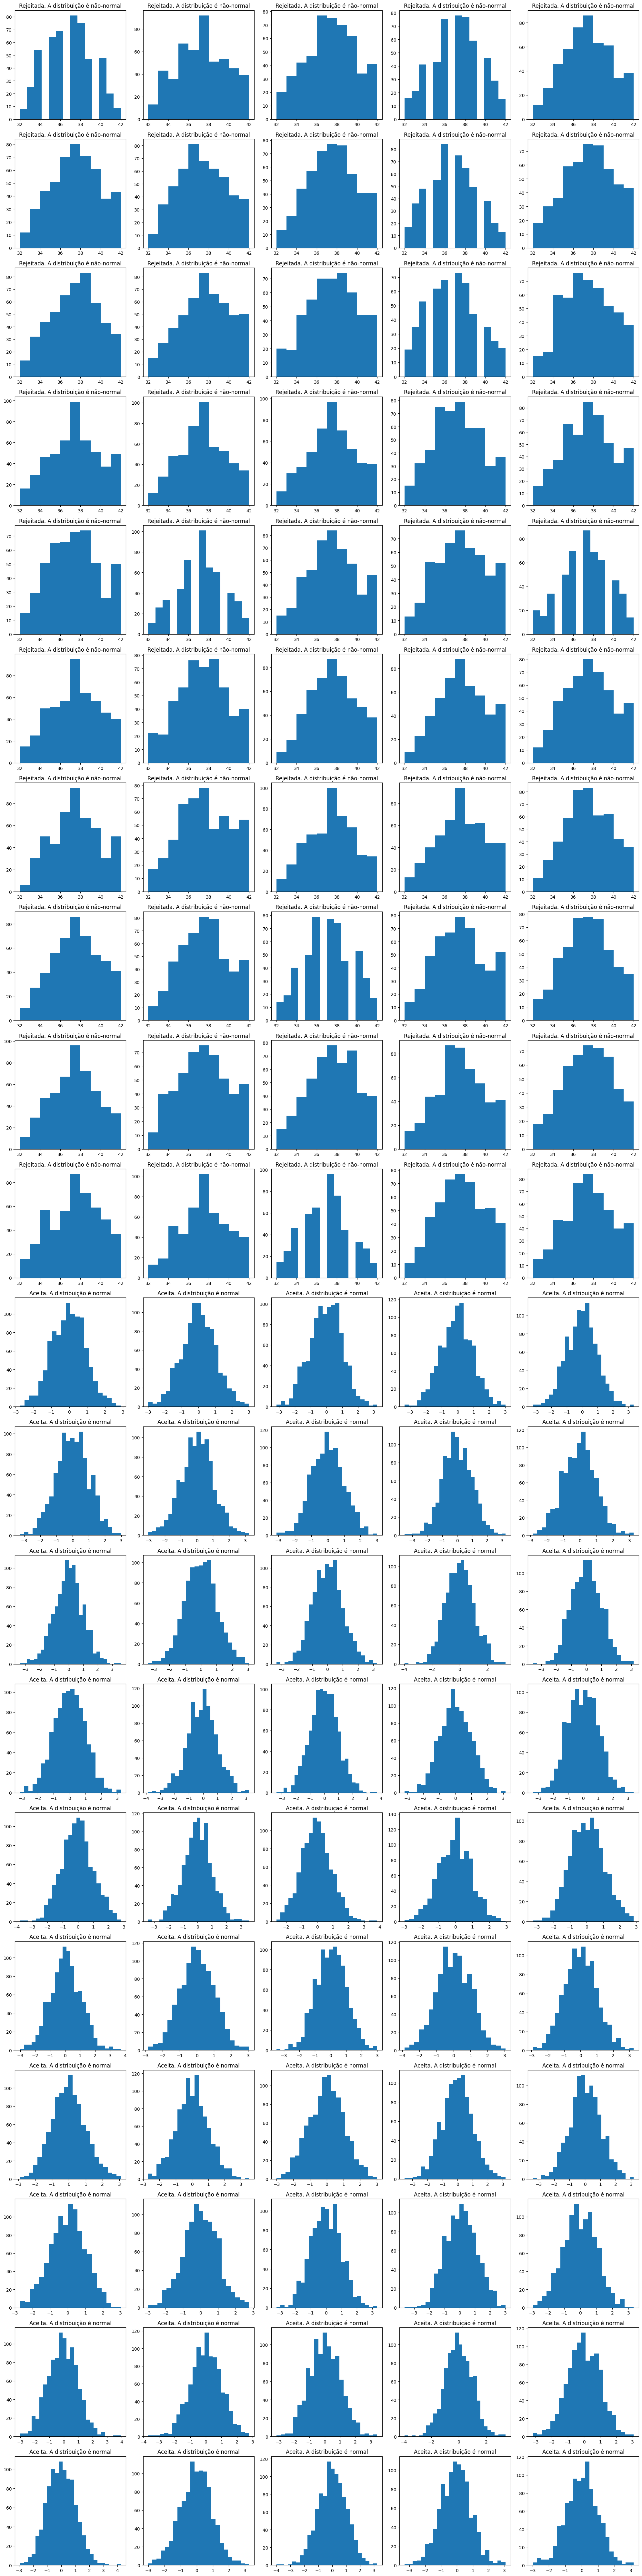

In [20]:
plotar_amostras(resultados_amostras_df)

In [23]:
#cria o df com informações do teste
df_info_teste = pd.DataFrame(resultados_amostras_df)
df_info_teste

,media,erro_padrao,desvio_padrao,variancia,minimo,maximo,soma,contagem,Dcalc,Dc,hipotese,amostra
0,36.878000,0.072713,2.299373,5.287116,32.000000,42.000000,NaN,1000,0.496536,0.042985,Rejeitada. A distribuição é não-normal,0 35.0 1 38.0 2 35.0 3 34....
1,36.836000,0.077904,2.463555,6.069104,32.000000,42.000000,NaN,1000,0.493970,0.042985,Rejeitada. A distribuição é não-normal,0 34.0 1 33.0 2 36.0 3 34....
2,36.894000,0.077941,2.464704,6.074764,32.000000,42.000000,NaN,1000,0.493594,0.042985,Rejeitada. A distribuição é não-normal,0 32.0 1 41.0 2 37.0 3 37....
3,37.152000,0.076242,2.410995,5.812896,32.000000,42.000000,NaN,1000,0.493311,0.042985,Rejeitada. A distribuição é não-normal,0 37.0 1 35.0 2 40.0 3 38....
4,36.914000,0.074341,2.350873,5.526604,32.000000,42.000000,NaN,1000,0.497363,0.042985,Rejeitada. A distribuição é não-normal,0 39.0 1 36.0 2 38.0 3 37....
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.005585,0.031471,0.995211,0.990445,-2.941636,4.238375,5.585336,1000,0.022065,0.042985,Aceita. A distribuição é normal,0 0.591657 1 -0.165072 2 -0.02336...
96,-0.032087,0.031281,0.989191,0.978498,-3.008356,3.250420,-32.087407,1000,0.022781,0.042985,Aceita. A distribuição é normal,0 -0.156918 1 -1.161672 2 -0.02995...
97,0.009244,0.032052,1.013580,1.027345,-4.012528,3.244073,9.243996,1000,0.016816,0.042985,Aceita. A distribuição é normal,0 0.493289 1 -1.041245 2 0.50923...
98,-0.069223,0.030386,0.960898,0.923325,-3.304717,3.063561,-69.222633,1000,0.015563,0.042985,Aceita. A distribuição é normal,0 0.053174 1 -1.059768 2 0.32961...
